In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import swyft

from swyft.inference.marginalratioestimator import MarginalRatioEstimator
from swyft.networks.classifier import get_marginal_classifier

# Setup the forward model

In [4]:
device = 'cuda' if swyft.utils.is_cuda_available() else "cpu"
n_training_samples = 3000
n_parameters = 2
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginals(n_parameters)
observation_key = "x"

In [5]:
def model(v, sigma = 0.2):
    x = v + np.random.randn(n_parameters) * sigma
    return {observation_key: x}

v_o = np.zeros(n_parameters)
observation_o = model(v_o, sigma = 0.)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

In [6]:
simulator = swyft.Simulator(
    model, 
    n_parameters, 
    sim_shapes={observation_key: (n_parameters,)}
)

# Setup the prior and storage

In [7]:
store = swyft.Store.memory_store(simulator)

Creating new store.


In [8]:
low = -1 * np.ones(n_parameters)
high = 1 * np.ones(n_parameters)
prior = swyft.get_uniform_prior(low, high)
store.add(n_training_samples, prior)
store.simulate()

Store: Adding 3064 new samples to simulator store.


In [9]:
dataset = swyft.Dataset(n_training_samples, prior, store)

# Train a 1d marginal estimator

In [10]:
network_1d = get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [11]:
mre_1d.train(dataset)

training: lr=5e-06, epoch=25, validation loss=1.6213

In [12]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
weighted_samples_1d = posterior_1d.weighted_sample(10_000, observation_o)

In [13]:
# TODO plot the 1d marginals
# 
# weighted_samples.get_df_dict()

# Train a 2d marginal estimator

In [14]:
network_2d = get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_2d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_2d = MarginalRatioEstimator(
    marginal_indices=marginal_indices_2d,
    network=network_2d,
    device=device,
)

In [15]:
mre_2d.train(dataset)

training: lr=5e-05, epoch=25, validation loss=0.37332

In [16]:
posterior_2d = swyft.MarginalPosterior(mre_2d, prior)
weighted_samples_2d = posterior_2d.weighted_sample(10_000, observation_o)

# Combine the two to create a corner plot

In [17]:
df_dict = weighted_samples_1d.get_df_dict()
df_dict.update(weighted_samples_2d.get_df_dict())
print(df_dict.keys())

dict_keys([(0,), (1,), (0, 1)])


1it [00:04,  4.00s/it]


(<Figure size 432x288 with 4 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

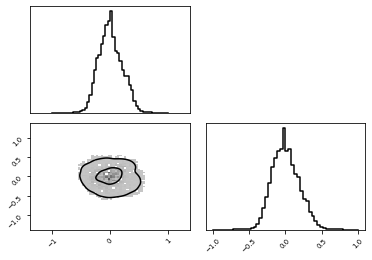

In [18]:
swyft.plot.corner(df_dict, kde=True)